In [9]:
#匯入函式庫
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:

#顯示圖片
def show_image(title, img):
    if img.ndim == 2: #灰階處理
        plt.imshow(img, cmap='gray')
    else:  #彩色
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

#計算暗通道
def DarkChannel(im, sz):
    #對每個像素取RGB中的最小值得到灰階圖
    min_channel = np.min(im, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (sz, sz))
    #對灰階圖做腐蝕強化暗區
    dark_channel = cv2.erode(min_channel, kernel)

    return dark_channel

#估計大氣光
def AtmLight(im, dark):
    h, w = dark.shape
    #取暗通道中亮度最高的前0.1%像素
    numpx = max((h * w) // 1000, 1)
    #將暗通道圖拉平成一維陣列後排序，取最亮的numpx個像素位置
    indices = dark.ravel().argsort()[-numpx:]
    #從原始影像中取得這些像素位置的RGB值，並選出最亮者
    brightest = im.reshape(-1, 3)[indices]
    A = brightest[np.sum(brightest, axis=1).argmax()]

    return A

#估計初始傳輸率圖
def TransmissionEstimate(im, A, sz, omega=0.95):
    #影像通道除以大氣光以進行去除光照偏移的正規化
    normed = im / (A + 1e-6) 
    dark_channel = DarkChannel(normed, sz)
    #omega=控制霧保留程度
    t = 1 - omega * dark_channel

    return t

#使用OpenCV-contrib的快速導向濾波
def TransmissionRefine(im, te):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.float32) / 255
    te = te.astype(np.float32)
    #使用OpenCV-contrib中的ximgproc.guidedFilter
    guided = cv2.ximgproc.guidedFilter(guide=gray, src=te, radius=30, eps=1e-3)
    return guided

#去霧
def Recover(im, t, A, tx=0.25):
    t = np.maximum(t, tx)[:, :, None]
    # 以I(x) = J(x)t(x) + A 推導復原公式
    J = (im - A) / t + A
    return np.clip(J, 0, 1)

圖片載入成功，大小： (488, 800, 3)


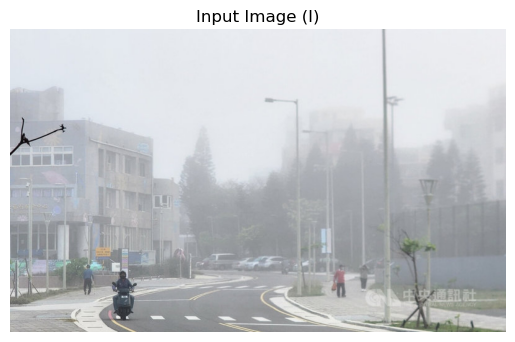

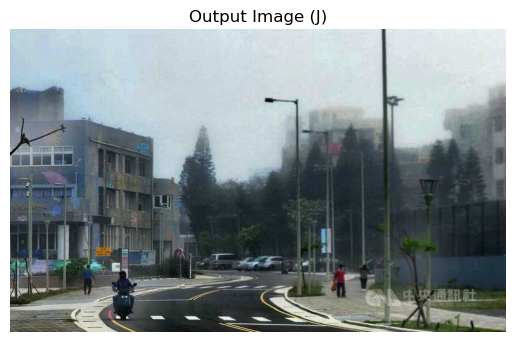

In [13]:
if __name__ == '__main__':
    fn = 'img.jpg'
    src = cv2.imread(fn)
    if src is None:
        print(f"無法讀取圖片：{fn}")
        exit(1)

    I = src.astype(np.float64) / 255
    print("圖片載入成功，大小：", I.shape)

    dark = DarkChannel(I, 15)
    A = AtmLight(I, dark)
    te = TransmissionEstimate(I, A, 15)
    t = TransmissionRefine(src, te)
    J = Recover(I, t, A)

    #進行簡單降噪
    J_uint8 = (J * 255).astype(np.uint8)
    J_denoised = cv2.bilateralFilter(J_uint8, d=9, sigmaColor=75, sigmaSpace=75)


    show_image("Input Image (I)", src)
    show_image("Output Image (J)", (J * 255).astype(np.uint8))